# Programming: Numerical Optimization for Logistic Regression.

### Name: Syed Aziz


## 0. Do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run this code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

file_path = r'D:\Stevens Class Files\Current Semester\CS_583_Deep_Learning\ProgrammingAssignment\M3 F1 Assignment implement Logistic Regression Due Mar 12\diabetes'
x_sparse, y = datasets.load_svmlight_file(file_path)

x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.03680081  0.04248677  0.05312717 -0.01551814  0.09127271 -0.0435057
   0.01698914  0.00013427]]
test std = 
[[1.02279521 1.13220209 0.94975102 0.93544651 1.04739    1.00142043
  0.93064312 1.05798164]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [5]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [6]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [7]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [8]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [9]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5905846869299953
Objective value at t=2 is 0.54749800330574
Objective value at t=3 is 0.5241904707942041
Objective value at t=4 is 0.509701198612987
Objective value at t=5 is 0.4999611055588487
Objective value at t=6 is 0.4930857655187659
Objective value at t=7 is 0.48806763481237486
Objective value at t=8 is 0.4843138352520546
Objective value at t=9 is 0.48145164256225065
Objective value at t=10 is 0.4792353327849787
Objective value at t=11 is 0.47749702261252425
Objective value at t=12 is 0.4761187562114104
Objective value at t=13 is 0.4750157484953925
Objective value at t=14 is 0.4741258829195633
Objective value at t=15 is 0.47340290041677924
Objective value at t=16 is 0.4728118572505666
Objective value at t=17 is 0.4723260242577267
Objective value at t=18 is 0.47192472707994293
Objective value at t=19 is 0.4715918150699423
Objective value at t=20 is 0.4713145587138521
Objective value at t=21 is 0.4710828443505

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [10]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [11]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [12]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5294445428642178
Objective value at epoch t=1 is 0.5172414824280882
Objective value at epoch t=2 is 0.508937829877355
Objective value at epoch t=3 is 0.5079995274896241
Objective value at epoch t=4 is 0.5102227351352863
Objective value at epoch t=5 is 0.5034489864946724
Objective value at epoch t=6 is 0.4980949551390693
Objective value at epoch t=7 is 0.49643275170754847
Objective value at epoch t=8 is 0.49439228974145466
Objective value at epoch t=9 is 0.49159550768249244
Objective value at epoch t=10 is 0.4884582917300181
Objective value at epoch t=11 is 0.4868513506559303
Objective value at epoch t=12 is 0.4867051534983561
Objective value at epoch t=13 is 0.4823286298742124
Objective value at epoch t=14 is 0.48480922252851677
Objective value at epoch t=15 is 0.482557209418657
Objective value at epoch t=16 is 0.48138393125621076
Objective value at epoch t=17 is 0.4807521600254881
Objective value at epoch t=18 is 0.4785430543582848
Objective value at 

# 4. Compare GD with SGD

Plot objective function values against epochs.

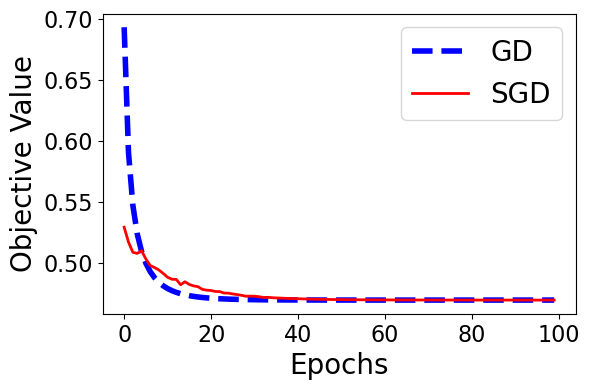

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', linewidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', linewidth=2)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [14]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [15]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2203125


In [16]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.2109375


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [23]:
import numpy as np
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i


def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    yx = np.multiply(yi,xi)  # Flatten yi to a 1D array for broadcasting
    
    
    # Directly use broadcasting for element-wise multiplication
    #yx = yi * xi  # yi[:, None] makes yi two-dimensional

    yxw = np.dot(yx, w)
    vec1 = np.exp(-yxw)
    vec2 = np.divide(yx, 1 + np.exp(yxw))
    obj = np.mean(np.log(1 + vec1)) + (lam / 2) * np.sum(w. T * w)

    g_loss = -np.mean(vec2, axis=0).reshape(-1, 1)
    g = g_loss + lam * w

    return obj, g




## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [24]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = np.zeros(max_epoch)
    if w is None:
        w = np.zeros((d, 1))
    
    for epoch in range(max_epoch):
        rand_indices = np.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval_epoch = 0  # Objective for this epoch
        for i in range(0, n, b):  # Iterate over batches
            end_index = min(i + b, n)
            xi_batch = x_rand[i:end_index, :]
            yi_batch = y_rand[i:end_index, :]
            
            
            # Compute objective and gradient for the batch
            actual_batch_size = end_index - i  # This may be less than b for the last batch
            obj_batch, g_batch = mb_stochastic_objective_gradient(w, xi_batch, yi_batch, lam, actual_batch_size)
            
            # Update weights
            w -= stepsize * g_batch
            
            # Aggregate the objective value
            objval_epoch += obj_batch * actual_batch_size
        
        # Average the objective value over all samples
        objvals[epoch] = objval_epoch / n
        
        # Optional: Decrease stepsize
        stepsize *= 0.9
        
        print('Objective value at epoch {} is {}'.format(epoch, objvals[epoch]))
    
    return w, objvals


## 6.3. Run MB-SGD

In [30]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.1 # you must tune this parameter Previous attempts: .1,

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch 0 is 0.5446098122497252
Objective value at epoch 1 is 0.4849043900929533
Objective value at epoch 2 is 0.4790981868091735
Objective value at epoch 3 is 0.4763854732759193
Objective value at epoch 4 is 0.4752691081727617
Objective value at epoch 5 is 0.47501210956693357
Objective value at epoch 6 is 0.4741533808947539
Objective value at epoch 7 is 0.473672674689359
Objective value at epoch 8 is 0.4731885826723068
Objective value at epoch 9 is 0.4727671199836019
Objective value at epoch 10 is 0.47295956412237733
Objective value at epoch 11 is 0.4725752867980654
Objective value at epoch 12 is 0.47232422368033566
Objective value at epoch 13 is 0.4720221157893422
Objective value at epoch 14 is 0.4717834173681463
Objective value at epoch 15 is 0.4717195878291471
Objective value at epoch 16 is 0.47126643893812137
Objective value at epoch 17 is 0.4713205072630494
Objective value at epoch 18 is 0.4711146297929756
Objective value at epoch 19 is 0.4711804246637351
Objecti

In [31]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.8 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch 0 is 0.5492928072670189
Objective value at epoch 1 is 0.48491191839943537
Objective value at epoch 2 is 0.4773288106455788
Objective value at epoch 3 is 0.47657247753753673
Objective value at epoch 4 is 0.4746375991766195
Objective value at epoch 5 is 0.4749980152623513
Objective value at epoch 6 is 0.4751605896769588
Objective value at epoch 7 is 0.4735911627722107
Objective value at epoch 8 is 0.4740396526871581
Objective value at epoch 9 is 0.47390019231055386
Objective value at epoch 10 is 0.47263038890819714
Objective value at epoch 11 is 0.4723499715674021
Objective value at epoch 12 is 0.4729509859624101
Objective value at epoch 13 is 0.47144851950417677
Objective value at epoch 14 is 0.47171754293836904
Objective value at epoch 15 is 0.47213307243054164
Objective value at epoch 16 is 0.4716626278098068
Objective value at epoch 17 is 0.4710004344913883
Objective value at epoch 18 is 0.471369143527329
Objective value at epoch 19 is 0.47077602062074886
Obj

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

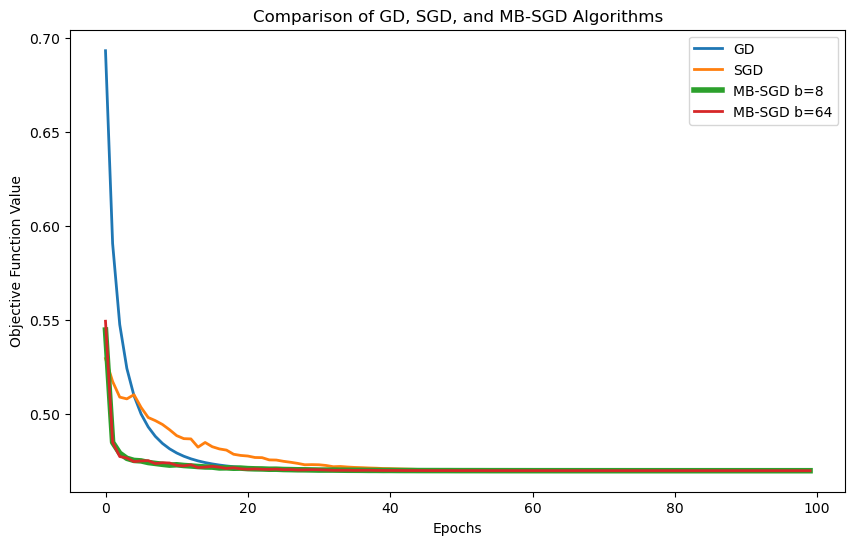

In [33]:
# plot the 4 curves:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot settings
plt.figure(figsize=(10, 6))

# Assuming objvals_gd, objvals_sgd, objvals_mbsgd8, objvals_mbsgd64 are defined
plt.plot(objvals_gd, label='GD', linewidth=2)
plt.plot(objvals_sgd, label='SGD', linewidth=2)
plt.plot(objvals_mbsgd8, label='MB-SGD b=8', linewidth=4)
plt.plot(objvals_mbsgd64, label='MB-SGD b=64', linewidth=2)

# Labeling the plot
plt.xlabel('Epochs')
plt.ylabel('Objective Function Value')
plt.title('Comparison of GD, SGD, and MB-SGD Algorithms')
plt.legend()

# Display the plot
plt.show()
